<h1>导入数据</h1>

In [111]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import pandas as pd
import time
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPool1D, Dropout, concatenate, Flatten, Conv1D, Lambda, BatchNormalization, ReLU, Activation, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import History, TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import Hinge
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.losses import TripletHardLoss, TripletSemiHardLoss
from tensorflow.keras.backend import clear_session, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.math import l2_normalize
from time import strftime, localtime
from itertools import combinations
from scipy.spatial import distance
from scipy.stats import entropy
from joblib import load, dump

<h1>数据处理</h1>

<h2>数据预处理</h2>

<h3>conf_info数据预处理</h3>

In [88]:
cons_info = pd.read_csv("../data/训练组_比特币挖矿_档案明细（20211220）.csv", index_col=0, quotechar='"', encoding="gbk")
cons_info

,ID,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE,IS_FLAG
,,,,,,,,,,,,,,
1,329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
2,329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
3,329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
4,329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
5,329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8836,2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/2 16:12:00,NaN,120.0,2019/12/2 16:12:00,非临时用电,NaN,0
8837,2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019/12/3 16:33:00,NaN,120.0,2019/12/3 16:33:00,非临时用电,NaN,0
8838,2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/18 14:42:00,NaN,120.0,2019/12/18 14:42:00,非临时用电,NaN,0


In [89]:
cons_info = cons_info.set_index("ID").drop(columns=["CANCEL_DATE", "TMP_DATE"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/2 16:12:00,120.0,2019/12/2 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019/12/3 16:33:00,120.0,2019/12/3 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/18 14:42:00,120.0,2019/12/18 14:42:00,非临时用电,0


In [90]:
cons_info["BUILD_DATE"] = pd.to_datetime(cons_info["BUILD_DATE"])
cons_info["LAST_CHK_DATE"] = pd.to_datetime(cons_info["LAST_CHK_DATE"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0


In [91]:
cons_info["SHIFT_NO"] = cons_info["SHIFT_NO"].fillna(0)
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0


In [92]:
cons_info["now"] = "2021-12-31"
cons_info["now"] = pd.to_datetime(cons_info["now"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG,now
ID,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0,2021-12-31
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0,2021-12-31
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0,2021-12-31


In [93]:
cons_info["live_days"] = (cons_info["now"] - cons_info["BUILD_DATE"]).map(lambda x: x.days)
cons_info["check_days"] = (cons_info["now"] - cons_info["LAST_CHK_DATE"]).map(lambda x: x.days)
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG,now,live_days,check_days
ID,,,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0,2021-12-31,759,759
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0,2021-12-31,758,758
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0,2021-12-31,743,743


In [94]:
cons_info = cons_info.drop(columns=["BUILD_DATE", "LAST_CHK_DATE", "now"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,TMP_NAME,IS_FLAG,live_days,check_days
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,240.0,非临时用电,0,6040,6040
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,240.0,非临时用电,0,6040,6040
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,240.0,非临时用电,0,6040,6040
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,240.0,非临时用电,0,6040,6040
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,240.0,非临时用电,0,6040,6040
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,120.0,非临时用电,0,759,759
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,120.0,非临时用电,0,758,758
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,120.0,非临时用电,0,743,743


In [95]:
cons_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 329465205 to 2529558569
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ELEC_TYPE_NAME  8840 non-null   object 
 1   VOLT_NAME       8840 non-null   object 
 2   PRC_NAME        8840 non-null   object 
 3   CONTRACT_CAP    8840 non-null   float64
 4   RUN_CAP         8840 non-null   float64
 5   SHIFT_NO        8840 non-null   float64
 6   CHK_CYCLE       8838 non-null   float64
 7   TMP_NAME        8840 non-null   object 
 8   IS_FLAG         8840 non-null   int64  
 9   live_days       8840 non-null   int64  
 10  check_days      8840 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 828.8+ KB


In [96]:
cons_info = pd.get_dummies(cons_info)
cons_info

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,IS_FLAG,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_居民生活用电,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民合表电价(不满1千伏）,TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
329465205,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465245,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465357,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465360,2.0,2.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465439,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,39.0,39.0,0.0,120.0,0,759,759,1,0,0,...,0,0,0,0,0,0,1,0,1,1
2864274650,13.0,13.0,0.0,120.0,0,758,758,1,0,0,...,0,0,0,0,0,1,0,0,1,1
2872313739,39.0,39.0,0.0,120.0,0,743,743,1,0,0,...,0,0,0,0,0,0,1,0,1,1


In [97]:
cons_info["CHK_CYCLE"] = cons_info["CHK_CYCLE"].fillna(cons_info["CHK_CYCLE"].median())
cons_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 329465205 to 2529558569
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CONTRACT_CAP                8840 non-null   float64
 1   RUN_CAP                     8840 non-null   float64
 2   SHIFT_NO                    8840 non-null   float64
 3   CHK_CYCLE                   8840 non-null   float64
 4   IS_FLAG                     8840 non-null   int64  
 5   live_days                   8840 non-null   int64  
 6   check_days                  8840 non-null   int64  
 7   ELEC_TYPE_NAME_乡村居民生活用电     8840 non-null   uint8  
 8   ELEC_TYPE_NAME_商业用电         8840 non-null   uint8  
 9   ELEC_TYPE_NAME_城镇居民生活用电     8840 non-null   uint8  
 10  ELEC_TYPE_NAME_学校教学和学生生活用电  8840 non-null   uint8  
 11  ELEC_TYPE_NAME_居民生活用电       8840 non-null   uint8  
 12  ELEC_TYPE_NAME_普通工业         8840 non-null   uint8  
 13  ELEC_TYPE_NAME_非居民照

<h3>elec_month数据预处理</h3>

In [12]:
elec_month = pd.read_csv("../data/训练组_比特币挖矿_月用电明细（20211217）.csv")
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,615,161,0,776
1,329769614,202002,492,154,-1,645
2,329769614,202003,457,114,1,572
3,329769614,202004,522,171,0,693
4,329769614,202005,519,181,0,700
...,...,...,...,...,...,...
194475,2878334859,202106,107,67,-1,173
194476,2878334859,202107,170,112,1,283
194477,2878334859,202108,102,67,0,169
194478,2878334859,202109,112,65,-1,176


In [13]:
elec_month["ym"] = elec_month["ym"].astype(str)
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,615,161,0,776
1,329769614,202002,492,154,-1,645
2,329769614,202003,457,114,1,572
3,329769614,202004,522,171,0,693
4,329769614,202005,519,181,0,700
...,...,...,...,...,...,...
194475,2878334859,202106,107,67,-1,173
194476,2878334859,202107,170,112,1,283
194477,2878334859,202108,102,67,0,169
194478,2878334859,202109,112,65,-1,176


elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]] = elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]] / elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]].max(axis=0)
elec_month

In [14]:
cons_month_result = []
for cons_id in tqdm(cons_info.index):
    df = elec_month[elec_month["id"] == cons_id]
    df = df.drop(columns=["id"]).sort_values("ym").set_index("ym")
    df = df.fillna(method="ffill").fillna(method="bfill").fillna(0)
    
    cons_month_result.append(df.values)
cons_month = np.array(cons_month_result)
cons_month.shape

100%|███████████████████████████████████████████████████████████████████████████████| 8840/8840 [00:14<00:00, 609.99it/s]


(8840, 22, 4)

<h3>elec_day数据预处理</h3>

In [15]:
elec_day = pd.read_csv("../data/训练组_比特币挖矿_日用电明细（20211217）.csv")
elec_day

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,329449398,2020-01-22 00:00:00,11.77,0.0,0.0,7.40,0.0,4.36
1,329449398,2020-01-23 00:00:00,16.54,0.0,0.0,8.68,0.0,7.86
2,329449398,2020-01-24 00:00:00,10.86,0.0,0.0,5.51,0.0,5.36
3,329449398,2020-01-25 00:00:00,10.91,0.0,0.0,6.48,0.0,4.43
4,329449398,2020-01-26 00:00:00,10.85,0.0,0.0,6.32,0.0,4.52
...,...,...,...,...,...,...,...,...
954564,2878334859,2021-10-05 00:00:00,7.22,NaN,0.0,4.49,0.0,2.73
954565,2878334859,2021-10-06 00:00:00,7.23,NaN,0.0,4.48,0.0,2.74
954566,2878334859,2021-10-07 00:00:00,7.20,NaN,0.0,4.48,0.0,2.73
954567,2878334859,2021-10-08 00:00:00,7.23,NaN,0.0,4.50,0.0,2.73


elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] = elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] / elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]].max(axis=0)
elec_day

In [16]:
dates = pd.to_datetime(elec_day["rq"].unique()).sort_values()

In [17]:
cons_day_result = []
for cons_id in tqdm(cons_info.index):
    df = elec_day[elec_day["id"] == cons_id].drop(columns=["id"]).sort_values("rq")
    df["rq"] = pd.to_datetime(df["rq"])
    df = df.set_index("rq").reindex(dates)
    df = df.fillna(method="ffill").fillna(method="bfill").fillna(0)
    
    cons_day_result.append(df.values)
cons_day = np.array(cons_day_result)
cons_day.shape

100%|███████████████████████████████████████████████████████████████████████████████| 8840/8840 [00:29<00:00, 299.27it/s]


(8840, 108, 6)

<h2>再处理数据</h2>

<h3>查看现有数据形状</h3>

<h4>标签</h4>

In [18]:
target = cons_info["IS_FLAG"].values.astype(np.float64)
target.shape

(8840,)

<h4>统一视图</h4>

In [19]:
cons_info_train = cons_info.drop(columns=["IS_FLAG"]).values
print(cons_info_train.shape)
print(np.isnan(cons_info_train).sum())

(8840, 20)
0


<h4>月均电量</h4>

In [20]:
print(cons_month.shape)
print(np.isnan(cons_month).sum())

(8840, 22, 4)
0


<h4>日电量</h4>

In [21]:
print(cons_day.shape)
print(np.isnan(cons_day).sum())

(8840, 108, 6)
0


<h1>提取特征向量</h1>

<h2>初始化tensorflow</h2>

In [22]:
clear_session()
tf.compat.v1.reset_default_graph()
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>构建一些特征算子</h2>

In [23]:
def assign_value(input_tensor, position=None, value=None):
    def assign(x, ijk=None, new_value=None):
        values = x.numpy()
        values[tuple(ijk)] = new_value
        return values
    return tf.py_function(assign, inp=[input_tensor, position, value], Tout=input_tensor.dtype)

In [24]:
def add_features(x, columns: [int]):
    """
    增加新的特征\n
    """
    if len(columns) == 0:
        return x
    for i, j in combinations(columns, r=2):
        feature = tf.expand_dims(x[:, :, i] - x[:, :, j], -1)
        x = tf.concat([x, feature], axis=-1)
    return x

In [25]:
def devide_features(x, columns: [int]):
    """
    增加新的特征\n
    """
    if len(columns) == 0:
        return x
    for i, j in combinations(columns, r=2):
        feature = tf.expand_dims((epsilon() + x[:, :, i]) / (epsilon() + x[:, :, j]), -1)
        x = tf.concat([x, feature], axis=-1)
    return x

In [26]:
def entropy_features(x, columns: [int], bins: int = 10):
    """
    计算一个数组的熵\n
    """
    if len(columns) == 0:
        return x
    data = tf.gather(x, indices=columns, axis=-1)
    edges = tf.linspace(tf.math.reduce_min(data), tf.math.reduce_max(data), num=bins + 1)
    bin_nums = tf.transpose(entropy_features(cons_day[0:16], [3, 4, 5]), perm=[1, 2, 0])
    result = entropy(bin_nums, axis=-1)
    result = tf.where(tf.math.is_nan(result), 0.0, result)
    return tf.concat([x, tf.expand_dims(result, -1)], axis=-1)

In [27]:
def variation_features(x, columns: [int]):
    """
    计算变异系数\n
    """
    if len(columns) == 0:
        return x
    result = tf.math.reduce_std(tf.gather(x, indices=columns, axis=-1), axis=-1) / (epsilon() + tf.math.reduce_mean(tf.gather(x, indices=columns, axis=-1), axis=-1))
    result = tf.where(tf.math.is_nan(result), 0.0, result)
    return tf.concat([x, tf.expand_dims(result, -1)], axis=-1)

<h2>提取月电量特征</h2>

<h3>构建月电量序列的特征提取器</h3>

In [28]:
def build_month_model(cons_month_shape) -> Model:
    input_cons_month = Input(shape=cons_month_shape, name="input_cons_month")
    
    y0 = BatchNormalization(name="y0", axis=-1)(input_cons_month)
    y1 = Lambda(lambda x: add_features(x, [0, 1, 2]), name="y1")(y0)
    y2, y_hidden_state, y_cell_state = LSTM(units=16, return_sequences=True, return_state=True, name="y2")(y1)
    y_hidden_state_2 = Dense(units=64, name="y_hidden_state_2")(y_hidden_state)
    y_cell_state_2 = Dense(units=64, name="y_cell_state_2")(y_cell_state)
    y3 = LSTM(units=64, return_sequences=False, return_state=False, name="y3")(y2, [y_hidden_state_2, y_cell_state_2])
    y4 = Flatten(name="y4")(y3)
    y5 = Dense(units=64, activation=None, name="y5")(y4)
    y6 = Lambda(lambda x: l2_normalize(x, axis=1), name="y6")(y5)
    
    result = Model(inputs=input_cons_month, outputs=y6, name="month_vector")
    result.summary()
    return result


month_model = build_month_model(cons_month.shape[1:])

Model: "month_vector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cons_month (InputLayer)   [(None, 22, 4)]      0                                            
__________________________________________________________________________________________________
y0 (BatchNormalization)         (None, 22, 4)        16          input_cons_month[0][0]           
__________________________________________________________________________________________________
y1 (Lambda)                     (None, 22, 7)        0           y0[0][0]                         
__________________________________________________________________________________________________
y2 (LSTM)                       [(None, 22, 16), (No 1536        y1[0][0]                         
_______________________________________________________________________________________

<h3>编译模型并训练</h3>

In [29]:
month_model.compile(
    loss=TripletSemiHardLoss(),
    optimizer=Adam(learning_rate=1e-4)
)
month_model_history = month_model.fit(
    cons_month,
    target,
    epochs=100,
    batch_size=64,
    use_multiprocessing=True,
    workers=12,
    callbacks=[
        TensorBoard(log_dir="../logs/%s" % strftime("%Y%m%d_%H.%M.%S", localtime()), write_graph=True, write_images=True),
#         ModelCheckpoint(filepath="../models/month_vector.h5", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-6)
    ]
).history

Epoch 1/100
  1/139 [..............................] - ETA: 0s - loss: 2.0938WARNING:tensorflow:From c:\users\drzon\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
139/139 [==============================] - 1s 9ms/step - loss: 1.6358
Epoch 2/100
139/139 [==============================] - 1s 7ms/step - loss: 1.0984
Epoch 3/100
139/139 [==============================] - 1s 7ms/step - loss: 0.9955
Epoch 4/100
139/139 [==============================] - 1s 7ms/step - loss: 0.9830
Epoch 5/100
139/139 [==============================] - 1s 7ms/step - loss: 0.9868
Epoch 6/100
139/139 [==============================] - 1s 7ms/step - loss: 0.9763
Epoch 7/100
139/139 [==============================] - 1s 7ms/step - loss: 0.9662
Epoch 8/100
139/139 [=============================

<h3>保存并加载模型</h3>

In [30]:
# save_model(model=month_model, filepath="../models/month_vector/")

In [31]:
month_model = load_model(filepath="../models/month_vector/", custom_objects={
    "add_features": add_features,
    "l2_normalize": l2_normalize
})

<h2>提取日电量特征</h2>

<h3>构建构建日电量特征提取的模型</h3>

In [32]:
def build_day_model(cons_day_shape) -> Model:
    input_cons_day = Input(shape=cons_day_shape, name="input_cons_day")

    z11 = Lambda(lambda x: add_features(x, [3, 4, 5]), name="z11")(input_cons_day)
    z12 = Lambda(lambda x: devide_features(x, [3, 4, 5]), name="z12")(z11)
    z13 = Lambda(lambda x: variation_features(x, [3, 4, 5]), name="z13")(z12)
    z1 = BatchNormalization(name="z1", axis=-1)(z13)
    z2, z_hidden_state, z_cell_state = LSTM(units=16, return_sequences=True, return_state=True, name="z2")(z1)
    z_hidden_state_2 = Dense(units=64, name="z_hidden_state_2", activation="relu")(z_hidden_state)
    z_cell_state_2 = Dense(units=64, name="z_cell_state_2", activation="relu")(z_cell_state)
    z3, z_hidden_state_, z_cell_state_ = LSTM(units=64, return_sequences=True, return_state=True, name="z3")(z2, [z_hidden_state_2, z_cell_state_2])
    z_hidden_state_3 = Dense(units=128, name="z_hidden_state_3", activation="relu")(z_hidden_state_)
    z_cell_state_3 = Dense(units=128, name="z_cell_state_3", activation="relu")(z_cell_state_)
    z4 = LSTM(units=128, return_sequences=False, return_state=False, name="z4")(z3, [z_hidden_state_3, z_cell_state_3])
    z5 = Flatten(name="z5")(z4)
    z6 = Dense(units=128, activation="relu", name="z6")(z5)
    z7 = BatchNormalization(name="z7", axis=-1)(z6)
    z8 = Dense(units=64, activation="relu", name="z8")(z7)
    z9 = BatchNormalization(name="z9", axis=-1)(z8)
    z10 = Dense(units=64, activation=None, name="z10")(z9)
    zout = Lambda(lambda x: l2_normalize(x, axis=1), name="zout")(z10)
    
    result = Model(inputs=input_cons_day, outputs=zout, name="day_vector")
    result.summary()
    return result


day_model = build_day_model(cons_day.shape[1:])

Model: "day_vector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cons_day (InputLayer)     [(None, 108, 6)]     0                                            
__________________________________________________________________________________________________
z11 (Lambda)                    (None, 108, 9)       0           input_cons_day[0][0]             
__________________________________________________________________________________________________
z12 (Lambda)                    (None, 108, 12)      0           z11[0][0]                        
__________________________________________________________________________________________________
z13 (Lambda)                    (None, 108, 13)      0           z12[0][0]                        
_________________________________________________________________________________________

<h3>编译模型并训练</h3>

In [33]:
day_model.compile(
    loss=TripletSemiHardLoss(),
    optimizer=Adam(learning_rate=1e-4)
)
day_model_history = day_model.fit(
    cons_day,
    target,
    epochs=100,
    batch_size=64,
    use_multiprocessing=True,
    workers=12,
    callbacks=[
        TensorBoard(log_dir="../logs/%s" % strftime("%Y%m%d_%H.%M.%S", localtime()), write_graph=True, write_images=True),
#         ModelCheckpoint(filepath="../models/day_vector.h5", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-6)
    ]
).history

Epoch 1/100
139/139 [==============================] - 4s 25ms/step - loss: 2.0373
Epoch 2/100
139/139 [==============================] - 3s 22ms/step - loss: 1.6672
Epoch 3/100
139/139 [==============================] - 3s 22ms/step - loss: 1.3652
Epoch 4/100
139/139 [==============================] - 3s 22ms/step - loss: 1.2320
Epoch 5/100
139/139 [==============================] - 3s 22ms/step - loss: 1.1180
Epoch 6/100
139/139 [==============================] - 3s 22ms/step - loss: 1.1232
Epoch 7/100
139/139 [==============================] - 3s 22ms/step - loss: 1.0932
Epoch 8/100
139/139 [==============================] - 3s 21ms/step - loss: 1.0838
Epoch 9/100
139/139 [==============================] - 3s 22ms/step - loss: 1.0701
Epoch 10/100
139/139 [==============================] - 3s 22ms/step - loss: 1.0570
Epoch 11/100
139/139 [==============================] - 3s 22ms/step - loss: 1.0471
Epoch 12/100
139/139 [==============================] - 3s 22ms/step - loss: 1.0459
E

<h3>保存并加载模型</h3>

In [54]:
# save_model(model=day_model, filepath="../models/day_vector/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/day_vector/assets


In [55]:
day_model = load_model(filepath="../models/day_vector/", custom_objects={
    "add_features": add_features,
    "devide_features": devide_features,
    "variation_features": variation_features,
    "l2_normalize": l2_normalize
})

<h1>查看效果</h1>

<h2>查看月电量特征效果</h2>

In [36]:
cons_month_pos = cons_month[target == 1]
cons_month_pos.shape

(10, 22, 4)

In [37]:
pos_month_code = month_model.predict(cons_month_pos)
pos_month_code.shape

(10, 64)

In [38]:
cons_month_neg = cons_month[target == 0][0:20]
cons_month_neg.shape

(20, 22, 4)

In [39]:
neg_month_code = month_model.predict(cons_month_neg)
neg_month_code.shape

(20, 64)

In [40]:
distance.euclidean(pos_month_code[2], pos_month_code[4])

0.3265288770198822

In [41]:
distance.euclidean(pos_month_code[2], neg_month_code[4])

1.9420349597930908

In [42]:
month_code = np.concatenate([pos_month_code, neg_month_code], axis=0)
month_code.shape

(30, 64)

In [43]:
month_distance = np.zeros((month_code.shape[0], month_code.shape[0]))
for i in range(month_code.shape[0]):
    for j in range(month_code.shape[0]):
        month_distance[i, j] = distance.euclidean(month_code[i], month_code[j])

month_distance.shape

(30, 30)

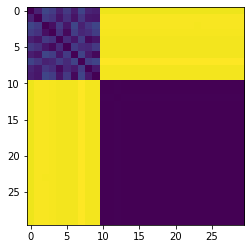

In [44]:
plt.figure(1)
plt.imshow(month_distance)
plt.show()

<h2>查看日电量特征效果</h2>

In [45]:
cons_day_pos = cons_day[target == 1]
cons_day_pos.shape

(10, 108, 6)

In [46]:
pos_day_code = day_model.predict(cons_day_pos)
pos_day_code.shape

(10, 64)

In [47]:
cons_day_neg = cons_day[target == 0][0:20]
cons_day_neg.shape

(20, 108, 6)

In [48]:
neg_day_code = day_model.predict(cons_day_neg)
neg_day_code.shape

(20, 64)

In [49]:
distance.euclidean(pos_day_code[2], pos_day_code[4])

0.002916133962571621

In [50]:
distance.euclidean(pos_day_code[2], neg_day_code[4])

0.02958064153790474

In [51]:
day_code = np.concatenate([pos_day_code, neg_day_code], axis=0)
day_code.shape

(30, 64)

In [52]:
day_distance = np.zeros((day_code.shape[0], day_code.shape[0]))
for i in range(day_code.shape[0]):
    for j in range(day_code.shape[0]):
        day_distance[i, j] = distance.euclidean(day_code[i], day_code[j])

day_distance.shape

(30, 30)

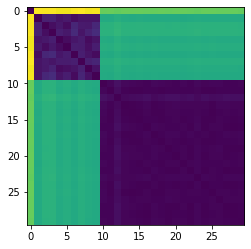

In [53]:
plt.figure(2)
plt.imshow(day_distance)
plt.show()

<h1>构建机器学习模型</h1>

<h2>准备数据</h2>

<h3>加入月电量特征</h3>

In [98]:
month_code = month_model.predict(cons_month)
month_df = pd.DataFrame(month_code, index=cons_info.index, columns=list(map(lambda x: "month_" + str(x), list(range(month_code.shape[1])))))
cons_info = cons_info.merge(month_df, left_index=True, right_index=True)
cons_info

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,IS_FLAG,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,month_54,month_55,month_56,month_57,month_58,month_59,month_60,month_61,month_62,month_63
ID,,,,,,,,,,,,,,,,,,,,,
329465205,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,-0.221082,0.041116,0.132632,0.006254,-0.076889,0.026536,0.152065,-0.206110,0.095581,0.213931
329465245,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,-0.221135,0.041198,0.132662,0.006226,-0.076814,0.026493,0.152227,-0.206030,0.095382,0.213862
329465357,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,-0.220836,0.041456,0.131488,0.006917,-0.077338,0.026727,0.152937,-0.206435,0.094819,0.214108
329465360,2.0,2.0,1.0,240.0,0,6040,6040,1,0,0,...,-0.221396,0.041426,0.132599,0.006258,-0.076723,0.026474,0.152126,-0.205930,0.095287,0.213796
329465439,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,-0.220717,0.041074,0.132503,0.006112,-0.077075,0.026435,0.152966,-0.206203,0.095129,0.213985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,39.0,39.0,0.0,120.0,0,759,759,1,0,0,...,-0.221576,0.041608,0.132826,0.006377,-0.076549,0.026402,0.152226,-0.205908,0.095075,0.213774
2864274650,13.0,13.0,0.0,120.0,0,758,758,1,0,0,...,-0.221182,0.041216,0.132763,0.006368,-0.077047,0.026567,0.151829,-0.206028,0.095450,0.213822
2872313739,39.0,39.0,0.0,120.0,0,743,743,1,0,0,...,-0.221163,0.041057,0.132710,0.006216,-0.076954,0.026419,0.152142,-0.206148,0.095329,0.213857


<h3>加入日电量特征</h3>

In [99]:
day_code = day_model.predict(cons_day)
day_df = pd.DataFrame(day_code, index=cons_info.index, columns=list(map(lambda x: "day_" + str(x), list(range(day_code.shape[1])))))
cons_info = cons_info.merge(day_df, left_index=True, right_index=True)
cons_info

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,IS_FLAG,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,day_54,day_55,day_56,day_57,day_58,day_59,day_60,day_61,day_62,day_63
ID,,,,,,,,,,,,,,,,,,,,,
329465205,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0.091565,0.106582,0.213066,0.174188,-0.133998,0.110339,-0.144853,-0.116844,-0.150529,0.138671
329465245,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0.091591,0.106627,0.213119,0.174220,-0.134104,0.110440,-0.144822,-0.116943,-0.150554,0.138733
329465357,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0.091500,0.106657,0.213292,0.174110,-0.134389,0.110502,-0.144868,-0.117017,-0.150764,0.138946
329465360,2.0,2.0,1.0,240.0,0,6040,6040,1,0,0,...,0.091556,0.106677,0.213106,0.174192,-0.134164,0.110433,-0.144831,-0.116983,-0.150592,0.138739
329465439,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0.091568,0.106645,0.213137,0.174203,-0.134130,0.110454,-0.144838,-0.116967,-0.150582,0.138766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,39.0,39.0,0.0,120.0,0,759,759,1,0,0,...,0.091639,0.106547,0.213155,0.174179,-0.134090,0.110382,-0.144850,-0.116872,-0.150521,0.138754
2864274650,13.0,13.0,0.0,120.0,0,758,758,1,0,0,...,0.091580,0.106636,0.213053,0.174296,-0.134080,0.110413,-0.144760,-0.116902,-0.150566,0.138616
2872313739,39.0,39.0,0.0,120.0,0,743,743,1,0,0,...,0.091427,0.106762,0.212965,0.174264,-0.134032,0.110596,-0.144731,-0.117035,-0.150572,0.138663


<h3>查看特征</h3>

In [100]:
cons_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 329465205 to 2529558569
Columns: 149 entries, CONTRACT_CAP to day_63
dtypes: float32(128), float64(4), int64(3), uint8(14)
memory usage: 5.3 MB


In [102]:
for column in cons_info.columns:
    print(column)

CONTRACT_CAP
RUN_CAP
SHIFT_NO
CHK_CYCLE
IS_FLAG
live_days
check_days
ELEC_TYPE_NAME_乡村居民生活用电
ELEC_TYPE_NAME_商业用电
ELEC_TYPE_NAME_城镇居民生活用电
ELEC_TYPE_NAME_学校教学和学生生活用电
ELEC_TYPE_NAME_居民生活用电
ELEC_TYPE_NAME_普通工业
ELEC_TYPE_NAME_非居民照明
ELEC_TYPE_NAME_非工业
VOLT_NAME_交流10kV
VOLT_NAME_交流220V
VOLT_NAME_交流380V
PRC_NAME_居民合表电价(1-10千伏）
PRC_NAME_居民合表电价(不满1千伏）
TMP_NAME_非临时用电
month_0
month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
month_13
month_14
month_15
month_16
month_17
month_18
month_19
month_20
month_21
month_22
month_23
month_24
month_25
month_26
month_27
month_28
month_29
month_30
month_31
month_32
month_33
month_34
month_35
month_36
month_37
month_38
month_39
month_40
month_41
month_42
month_43
month_44
month_45
month_46
month_47
month_48
month_49
month_50
month_51
month_52
month_53
month_54
month_55
month_56
month_57
month_58
month_59
month_60
month_61
month_62
month_63
day_0
day_1
day_2
day_3
day_4
day_5
day_6
day_7
day_8
day_9
day_10
day_11
d

In [103]:
x = cons_info.drop(columns=["IS_FLAG"])
y = cons_info["IS_FLAG"]
print(x.shape)
print(y.shape)

(8840, 148)
(8840,)


<h3>标准化</h3>

In [105]:
ss = StandardScaler()
x = ss.fit_transform(x)
x

array([[-0.31260749, -0.31917163,  1.05812375, ...,  0.2975162 ,
         0.27007594, -0.09108665],
       [-0.31260749, -0.31917163,  1.05812375, ...,  0.18931203,
         0.22999603,  0.05588227],
       [-0.2464131 , -0.25086739,  1.05812375, ...,  0.10835626,
        -0.10696241,  0.5687176 ],
       ...,
       [ 0.2665934 ,  0.27849043, -0.86811471, ...,  0.08947445,
         0.20109063, -0.11125956],
       [ 0.2665934 ,  0.27849043, -0.86811471, ...,  0.23100665,
         0.25670002, -0.18297353],
       [ 0.11765603,  0.1248059 , -0.86811471, ...,  0.19720658,
         0.23671988,  0.09801646]])

<h2>做出来一个模型</h2>

In [106]:
model = LGBMClassifier(n_estimators=500, objective="binary", learning_rate=0.1, class_weight="balanced")
model.fit(x, y)

LGBMClassifier(class_weight='balanced', n_estimators=500, objective='binary')

In [107]:
accuracy_score(y, model.predict(x))

1.0

In [108]:
f1_score(y, model.predict(x))

1.0

In [109]:
roc_auc_score(y, model.predict(x))

1.0

In [112]:
# dump(model, "../models/lightBGM-feature-vector.pkl")

['../models/lightBGM-feature-vector.pkl']

<h1>预测数据</h1>

<h2>数据预处理</h2>

<h3>档案信息处理</h3>

In [113]:
cons_info_test = pd.read_csv("../data/测试组_比特币挖矿_档案明细（20211220）.csv", index_col=0, quotechar='"', encoding="gbk")
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE
ID,,,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,NaN,24,1998/12/1,非临时用电,NaN
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,1998/12/1,NaN,24,1998/12/1,非临时用电,NaN
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999/4/1,NaN,24,1999/4/1,非临时用电,NaN
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999/3/1,NaN,36,1999/3/1,非临时用电,NaN
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,NaN,24,1998/12/1,非临时用电,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,2019/11/8 12:42:00,NaN,120,2019/11/8 12:42:00,非临时用电,NaN
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,NaN,2019/11/18 14:08:00,NaN,120,2019/11/18 14:08:00,非临时用电,NaN
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,NaN,2019/11/18 14:08:00,NaN,120,2019/11/18 14:08:00,非临时用电,NaN


In [114]:
cons_info_test = cons_info_test.drop(columns=["CANCEL_DATE", "TMP_DATE"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,24,1998/12/1,非临时用电
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,1998/12/1,24,1998/12/1,非临时用电
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999/4/1,24,1999/4/1,非临时用电
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999/3/1,36,1999/3/1,非临时用电
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,24,1998/12/1,非临时用电
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,2019/11/8 12:42:00,120,2019/11/8 12:42:00,非临时用电
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,NaN,2019/11/18 14:08:00,120,2019/11/18 14:08:00,非临时用电
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,NaN,2019/11/18 14:08:00,120,2019/11/18 14:08:00,非临时用电


In [115]:
cons_info_test["BUILD_DATE"] = pd.to_datetime(cons_info_test["BUILD_DATE"])
cons_info_test["LAST_CHK_DATE"] = pd.to_datetime(cons_info_test["LAST_CHK_DATE"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,NaN,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,NaN,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电


In [116]:
cons_info_test["SHIFT_NO"] = cons_info_test["SHIFT_NO"].fillna(0)
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电


In [117]:
cons_info_test["now"] = "2021-12-31"
cons_info_test["now"] = pd.to_datetime(cons_info_test["now"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,now
ID,,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电,2021-12-31
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电,2021-12-31
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电,2021-12-31
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31


In [118]:
cons_info_test["live_days"] = (cons_info_test["now"] - cons_info_test["BUILD_DATE"]).map(lambda x: x.days)
cons_info_test["check_days"] = (cons_info_test["now"] - cons_info_test["LAST_CHK_DATE"]).map(lambda x: x.days)
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,now,live_days,check_days
ID,,,,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31,8431,8431
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31,8431,8431
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电,2021-12-31,8310,8310
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电,2021-12-31,8341,8341
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31,8431,8431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电,2021-12-31,783,783
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31,773,773
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31,773,773


In [119]:
cons_info_test = cons_info_test.drop(columns=["BUILD_DATE", "LAST_CHK_DATE", "now"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,TMP_NAME,live_days,check_days
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,24,非临时用电,8431,8431
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,24,非临时用电,8431,8431
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,24,非临时用电,8310,8310
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,36,非临时用电,8341,8341
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,24,非临时用电,8431,8431
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,120,非临时用电,783,783
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,120,非临时用电,773,773
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,120,非临时用电,773,773


In [120]:
cons_info_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15379 entries, 179406029 to 2852368013
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ELEC_TYPE_NAME  15379 non-null  object 
 1   VOLT_NAME       15379 non-null  object 
 2   PRC_NAME        15379 non-null  object 
 3   CONTRACT_CAP    15379 non-null  float64
 4   RUN_CAP         15379 non-null  float64
 5   SHIFT_NO        15379 non-null  float64
 6   CHK_CYCLE       15379 non-null  int64  
 7   TMP_NAME        15379 non-null  object 
 8   live_days       15379 non-null  int64  
 9   check_days      15379 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 1.3+ MB


In [121]:
cons_info_test = pd.get_dummies(cons_info_test)
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406030,12.0,12.0,0.0,24,8431,8431,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406094,2.0,2.0,1.0,24,8310,8310,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406097,4.0,4.0,1.0,36,8341,8341,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406099,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1


In [122]:
cons_info_test["CHK_CYCLE"] = cons_info_test["CHK_CYCLE"].fillna(cons_info_test["CHK_CYCLE"].median())
cons_info_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15379 entries, 179406029 to 2852368013
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CONTRACT_CAP                15379 non-null  float64
 1   RUN_CAP                     15379 non-null  float64
 2   SHIFT_NO                    15379 non-null  float64
 3   CHK_CYCLE                   15379 non-null  int64  
 4   live_days                   15379 non-null  int64  
 5   check_days                  15379 non-null  int64  
 6   ELEC_TYPE_NAME_乡村居民生活用电     15379 non-null  uint8  
 7   ELEC_TYPE_NAME_农业生产用电       15379 non-null  uint8  
 8   ELEC_TYPE_NAME_商业用电         15379 non-null  uint8  
 9   ELEC_TYPE_NAME_城镇居民生活用电     15379 non-null  uint8  
 10  ELEC_TYPE_NAME_大工业用电        15379 non-null  uint8  
 11  ELEC_TYPE_NAME_学校教学和学生生活用电  15379 non-null  uint8  
 12  ELEC_TYPE_NAME_居民生活用电       15379 non-null  uint8  
 13  ELEC_TYPE_NAME_普通工

In [123]:
cons_info_test["PRC_NAME_居民合表电价(1-10千伏）"] = cons_info_test["PRC_NAME_居民合表电价(1-10千伏）"] + cons_info_test["PRC_NAME_居民生活1_10kV(合表)"]
cons_info_test = cons_info_test.drop(columns=["PRC_NAME_居民生活1_10kV(合表)"])
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406030,12.0,12.0,0.0,24,8431,8431,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406094,2.0,2.0,1.0,24,8310,8310,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406097,4.0,4.0,1.0,36,8341,8341,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406099,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [124]:
cons_info_test = cons_info_test.rename(columns={"PRC_NAME_居民生活<1kV(合表)": "PRC_NAME_居民合表电价(不满1千伏）"})
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民合表电价(不满1千伏）,TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406030,12.0,12.0,0.0,24,8431,8431,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406094,2.0,2.0,1.0,24,8310,8310,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406097,4.0,4.0,1.0,36,8341,8341,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
179406099,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [125]:
cons_info_test["VOLT_NAME_交流10kV"] = cons_info_test["VOLT_NAME_交流10kV"] + cons_info_test["VOLT_NAME_交流6kV"]
cons_info_test = cons_info_test.drop(columns=["VOLT_NAME_交流6kV"])
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_居民生活用电,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民合表电价(不满1千伏）,TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
179406030,12.0,12.0,0.0,24,8431,8431,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
179406094,2.0,2.0,1.0,24,8310,8310,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
179406097,4.0,4.0,1.0,36,8341,8341,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
179406099,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [126]:
cons_info_test["ELEC_TYPE_NAME_普通工业"] = cons_info_test["ELEC_TYPE_NAME_普通工业"] + cons_info_test["ELEC_TYPE_NAME_大工业用电"]
cons_info_test = cons_info_test.drop(columns=["ELEC_TYPE_NAME_大工业用电"])
cons_info_test["ELEC_TYPE_NAME_非工业"] = cons_info_test["ELEC_TYPE_NAME_非工业"] + cons_info_test["ELEC_TYPE_NAME_农业生产用电"]
cons_info_test = cons_info_test.drop(columns=["ELEC_TYPE_NAME_农业生产用电"])
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,ELEC_TYPE_NAME_学校教学和学生生活用电,ELEC_TYPE_NAME_居民生活用电,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民合表电价(不满1千伏）,TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,1,0,0,0,0,0,0,1,0,0,1,1
179406030,12.0,12.0,0.0,24,8431,8431,0,0,1,0,0,0,0,0,0,1,0,0,1,1
179406094,2.0,2.0,1.0,24,8310,8310,0,0,1,0,0,0,0,0,0,1,0,0,1,1
179406097,4.0,4.0,1.0,36,8341,8341,0,0,1,0,0,0,0,0,0,1,0,0,1,1
179406099,2.0,2.0,1.0,24,8431,8431,0,0,1,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,0,0,0,0,0,1,0,0,1,1
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,0,0,0,0,0,0,1,0,1,1
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,0,0,0,0,0,0,1,0,1,1


<h3>月电量特征</h3>

In [127]:
elec_month_test = pd.read_csv("../data/测试组_比特币挖矿_月用电明细（20211217）.csv")
elec_month_test

,id,ym,pq_f,pq_g,pq_p,pq_z
0,179438260,202001,244,111,1,356
1,179438260,202002,217,108,-1,324
2,179438260,202003,280,90,0,370
3,179438260,202004,338,118,1,457
4,179438260,202005,297,120,-1,416
...,...,...,...,...,...,...
338333,2880712108,202106,474,675,0,1149
338334,2880712108,202107,342,881,0,1223
338335,2880712108,202108,293,772,0,1065
338336,2880712108,202109,418,570,-1,987


In [128]:
elec_month_test["ym"] = elec_month_test["ym"].astype(str)
elec_month_test

,id,ym,pq_f,pq_g,pq_p,pq_z
0,179438260,202001,244,111,1,356
1,179438260,202002,217,108,-1,324
2,179438260,202003,280,90,0,370
3,179438260,202004,338,118,1,457
4,179438260,202005,297,120,-1,416
...,...,...,...,...,...,...
338333,2880712108,202106,474,675,0,1149
338334,2880712108,202107,342,881,0,1223
338335,2880712108,202108,293,772,0,1065
338336,2880712108,202109,418,570,-1,987


In [129]:
cons_month_test_result = []
for cons_id in tqdm(cons_info_test.index):
    df = elec_month_test[elec_month_test["id"] == cons_id]
    df = df.drop(columns=["id"]).sort_values("ym").set_index("ym")
    df = df.fillna(method="ffill").fillna(method="bfill").fillna(0)
    
    cons_month_test_result.append(df.values)
cons_month_test = np.array(cons_month_test_result)
cons_month_test.shape

100%|█████████████████████████████████████████████████████████████████████████████| 15379/15379 [00:24<00:00, 619.09it/s]


(15379, 22, 4)

In [131]:
month_test_code = month_model.predict(cons_month_test)
month_test_df = pd.DataFrame(month_test_code, index=cons_info_test.index, columns=list(map(lambda x: "month_" + str(x), list(range(month_test_code.shape[1])))))
cons_info_test = cons_info_test.merge(month_test_df, left_index=True, right_index=True)
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,ELEC_TYPE_NAME_学校教学和学生生活用电,...,month_54,month_55,month_56,month_57,month_58,month_59,month_60,month_61,month_62,month_63
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,1,0,...,-0.221117,0.041069,0.132607,0.006102,-0.076840,0.026365,0.152196,-0.206103,0.095352,0.213929
179406030,12.0,12.0,0.0,24,8431,8431,0,0,1,0,...,-0.221114,0.041234,0.132700,0.006279,-0.077087,0.026366,0.152161,-0.205963,0.095394,0.213880
179406094,2.0,2.0,1.0,24,8310,8310,0,0,1,0,...,-0.220920,0.041212,0.132535,0.006343,-0.077282,0.026579,0.151852,-0.206013,0.095597,0.213288
179406097,4.0,4.0,1.0,36,8341,8341,0,0,1,0,...,-0.221015,0.040903,0.132694,0.006118,-0.076911,0.026424,0.152257,-0.206219,0.095446,0.213911
179406099,2.0,2.0,1.0,24,8431,8431,0,0,1,0,...,-0.221417,0.041062,0.132650,0.006179,-0.076979,0.026213,0.152131,-0.206215,0.095314,0.213794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,-0.221306,0.041142,0.132693,0.006014,-0.076777,0.026182,0.152462,-0.206037,0.095262,0.213869
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,-0.221162,0.041056,0.132714,0.006215,-0.076955,0.026419,0.152144,-0.206148,0.095328,0.213857
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,-0.224940,0.065369,0.145786,-0.000200,-0.054971,0.033759,0.130207,-0.173388,0.067400,0.229222


<h3>日电量特征</h3>

In [132]:
elec_day_test = pd.read_csv("../data/测试组_比特币挖矿_日用电明细（20211217）.csv")
elec_day_test

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,179404030,2020-01-22 00:00:00,51.77,NaN,0.0,33.47,0.0,18.31
1,179404030,2020-01-23 00:00:00,73.27,NaN,0.0,51.83,0.0,21.44
2,179404030,2020-01-24 00:00:00,74.90,NaN,0.0,52.20,0.0,22.70
3,179404030,2020-01-25 00:00:00,62.73,NaN,0.0,37.27,0.0,25.45
4,179404030,2020-01-26 00:00:00,64.27,NaN,0.0,41.72,0.0,22.56
...,...,...,...,...,...,...,...,...
1660582,2880712108,2021-10-05 00:00:00,44.85,NaN,0.0,22.14,0.0,22.71
1660583,2880712108,2021-10-06 00:00:00,28.89,NaN,0.0,14.94,0.0,13.95
1660584,2880712108,2021-10-07 00:00:00,51.10,NaN,0.0,27.27,0.0,23.84
1660585,2880712108,2021-10-08 00:00:00,17.96,NaN,0.0,7.19,0.0,10.76


In [133]:
elec_day_test["rq"] = pd.to_datetime(elec_day_test["rq"])
elec_day_test

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,179404030,2020-01-22,51.77,NaN,0.0,33.47,0.0,18.31
1,179404030,2020-01-23,73.27,NaN,0.0,51.83,0.0,21.44
2,179404030,2020-01-24,74.90,NaN,0.0,52.20,0.0,22.70
3,179404030,2020-01-25,62.73,NaN,0.0,37.27,0.0,25.45
4,179404030,2020-01-26,64.27,NaN,0.0,41.72,0.0,22.56
...,...,...,...,...,...,...,...,...
1660582,2880712108,2021-10-05,44.85,NaN,0.0,22.14,0.0,22.71
1660583,2880712108,2021-10-06,28.89,NaN,0.0,14.94,0.0,13.95
1660584,2880712108,2021-10-07,51.10,NaN,0.0,27.27,0.0,23.84
1660585,2880712108,2021-10-08,17.96,NaN,0.0,7.19,0.0,10.76


In [141]:
cons_day_test_result = []
for cons_id in tqdm(cons_info_test.index):
    df = elec_day_test[elec_day_test["id"] == cons_id]
    df = df.drop(columns=["id"]).sort_values("rq").set_index("rq").reindex(dates)
    df = df.fillna(method="ffill").fillna(method="bfill").fillna(0)
    
    cons_day_test_result.append(df.values)
cons_day_test = np.array(cons_day_test_result)
cons_day_test.shape

100%|█████████████████████████████████████████████████████████████████████████████| 15379/15379 [00:59<00:00, 260.53it/s]


(15379, 108, 6)

In [143]:
day_test_code = day_model.predict(cons_day_test)
day_test_df = pd.DataFrame(day_test_code, index=cons_info_test.index, columns=list(map(lambda x: "day_" + str(x), list(range(day_test_code.shape[1])))))
cons_info_test = cons_info_test.merge(day_test_df, left_index=True, right_index=True)
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,ELEC_TYPE_NAME_学校教学和学生生活用电,...,day_54,day_55,day_56,day_57,day_58,day_59,day_60,day_61,day_62,day_63
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,1,0,...,0.091590,0.106628,0.213108,0.174219,-0.134080,0.110410,-0.144837,-0.116932,-0.150550,0.138716
179406030,12.0,12.0,0.0,24,8431,8431,0,0,1,0,...,0.091357,0.106643,0.213625,0.174415,-0.133960,0.111639,-0.144737,-0.117414,-0.150678,0.139548
179406094,2.0,2.0,1.0,24,8310,8310,0,0,1,0,...,0.091506,0.106678,0.213151,0.174240,-0.134062,0.110528,-0.144853,-0.117007,-0.150617,0.138800
179406097,4.0,4.0,1.0,36,8341,8341,0,0,1,0,...,0.091596,0.106604,0.213133,0.174211,-0.134080,0.110411,-0.144845,-0.116917,-0.150553,0.138738
179406099,2.0,2.0,1.0,24,8431,8431,0,0,1,0,...,0.091528,0.106644,0.213079,0.174243,-0.134082,0.110506,-0.144772,-0.116944,-0.150574,0.138711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0.091507,0.106772,0.213073,0.174211,-0.134092,0.110377,-0.144912,-0.117045,-0.150625,0.138712
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0.091427,0.106762,0.212965,0.174264,-0.134032,0.110596,-0.144731,-0.117035,-0.150572,0.138663
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0.094385,0.109015,0.215027,0.180734,-0.133850,0.111871,-0.145665,-0.119813,-0.152773,0.140628


<h2>数据集划分</h2>

<h3>重新排列测试集</h3>

In [144]:
cons_info_test = cons_info_test.reindex(columns=cons_info.columns).drop(columns=["IS_FLAG"])
cons_info_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15379 entries, 179406029 to 2852368013
Columns: 148 entries, CONTRACT_CAP to day_63
dtypes: float32(128), float64(3), int64(3), uint8(14)
memory usage: 9.2 MB


In [145]:
x_test = ss.transform(cons_info_test.values)
x_test.shape

(15379, 148)

In [146]:
x_test

array([[-0.34570468, -0.35332375,  1.05812375, ...,  0.20134919,
         0.23621739,  0.01485687],
       [-0.18021871, -0.18256316, -0.86811471, ..., -0.32463948,
         0.03112785,  2.01229649],
       [-0.34570468, -0.35332375,  1.05812375, ...,  0.11988068,
         0.12911428,  0.2166217 ],
       ...,
       [11.53618784, 11.90728646, -0.86811471, ..., -2.94500355,
        -3.33290517,  4.60580257],
       [-0.18021871, -0.18256316, -0.86811471, ...,  0.13284565,
         0.15976644,  0.16565292],
       [ 0.48999946,  0.50901722, -0.86811471, ..., -3.8509317 ,
        -3.22211711, -0.66551374]])

<h2>预测数据</h2>

In [147]:
y_test = model.predict(x_test)
cons_info_test["label"] = y_test
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,ELEC_TYPE_NAME_学校教学和学生生活用电,...,day_55,day_56,day_57,day_58,day_59,day_60,day_61,day_62,day_63,label
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,1,0,...,0.106628,0.213108,0.174219,-0.134080,0.110410,-0.144837,-0.116932,-0.150550,0.138716,0
179406030,12.0,12.0,0.0,24,8431,8431,0,0,1,0,...,0.106643,0.213625,0.174415,-0.133960,0.111639,-0.144737,-0.117414,-0.150678,0.139548,0
179406094,2.0,2.0,1.0,24,8310,8310,0,0,1,0,...,0.106678,0.213151,0.174240,-0.134062,0.110528,-0.144853,-0.117007,-0.150617,0.138800,0
179406097,4.0,4.0,1.0,36,8341,8341,0,0,1,0,...,0.106604,0.213133,0.174211,-0.134080,0.110411,-0.144845,-0.116917,-0.150553,0.138738,0
179406099,2.0,2.0,1.0,24,8431,8431,0,0,1,0,...,0.106644,0.213079,0.174243,-0.134082,0.110506,-0.144772,-0.116944,-0.150574,0.138711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0.106772,0.213073,0.174211,-0.134092,0.110377,-0.144912,-0.117045,-0.150625,0.138712,0
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0.106762,0.212965,0.174264,-0.134032,0.110596,-0.144731,-0.117035,-0.150572,0.138663,0
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0.109015,0.215027,0.180734,-0.133850,0.111871,-0.145665,-0.119813,-0.152773,0.140628,0


In [148]:
cons_info_test.index.name = "id"
cons_info_test[["label"]].to_csv("../data/result20220223-1.csv", index=True)